In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, RBF, Linear

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import pickle

import high_dim_power as hd

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as pyplot
mpl.rcParams["mathtext.fontset"] = "cm"

# MMD

In [407]:
tf.random.set_seed(1)

DELTA = 2.

BANDWIDTH_POWER = 0.

STATISTIC = "mmd"

KERNEL = RBF

dims = [27]
d = dims[0]

gammas = [3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8]
ns = [20] * len(dims)

DIR = f"../res/high_dim/gamma_mmd_dim{d}_n{ns[0]}"
SUFFIX = f"delta{DELTA}_r{BANDWIDTH_POWER}_{KERNEL.__name__}"

# Load results

In [411]:
res_exact_list = []
stats_res_list = []
for g in gammas:
    if int(g) != g:
        # load analytical res
        res = pd.read_csv(
            f"{DIR}/res_analytical_{SUFFIX}_gammammd_{g}.csv",
        )
        
        # load empirical results
        stats_res = pickle.load(
            open(f"{DIR}/stats_res_rep_{SUFFIX}_gammammd_{g}.p", "rb"),
        )
    
    else:
        # load analytical res
        res = pd.read_csv(
            f"{DIR}/res_analytical_{SUFFIX}_gammammd_{g}..csv",
        )
     
        # load empirical results
        stats_res = pickle.load(
            open(f"{DIR}/stats_res_rep_{SUFFIX}_gammammd_{g}..p", "rb"),
        )

    res = res.set_index("dim", drop=False)
    res_exact_list.append(res)
    
    stats_res_list.append(stats_res)

# Initialise result classes

In [6]:
def initialize_class(g_ind, gammas, res_exact_list,stats_res_list, ts=None):
    d = dims[-1]
    g_small = gammas[g_ind]
    print("dim:", d, "gamma:", g_small)
    
    if ts is None:
        ts = res_exact_list[g_ind].loc[d, "expectation"] * np.linspace(.25, 1.75, 101)

    lim_res = hd.LimitDistExperimentRepeatedMultiDims(
        empirical_vals_dims_list=stats_res_list[g_ind],
        res_analytical=res_exact_list[g_ind],
        dims=dims,
        ns=ns,
        ts=ts,
    )
    return lim_res

In [413]:
lim_res_list = []
for i, g in enumerate(gammas):
    lim_res = initialize_class(
        g_ind=i, 
        gammas=gammas, 
        res_exact_list=res_exact_list,
        stats_res_list=stats_res_list,
    )
    lim_res_list.append(lim_res)

dim: 27 gamma: 3
dim: 27 gamma: 3.2
dim: 27 gamma: 3.4
dim: 27 gamma: 3.6
dim: 27 gamma: 3.8
dim: 27 gamma: 4
dim: 27 gamma: 4.2
dim: 27 gamma: 4.4
dim: 27 gamma: 4.6
dim: 27 gamma: 4.8


## distance

In [414]:
dist_rep_list = []
for i, g in enumerate(gammas):
    try:
        dist_rep = lim_res_list[i].compute_distance(size=100000)
        dist_rep["gamma"] = g
        dist_rep_list.append(dist_rep)
    
    except:
        pass

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


In [415]:
labels = {
    "cond": "Non-degen.", 
    "mm_full": "Degen. Gamma",
#     "mm_chi": "Degen. Chi-square",
}

dist_rep_df = pd.concat(dist_rep_list, ignore_index=True)
dist_rep_df.replace(labels, inplace=True)

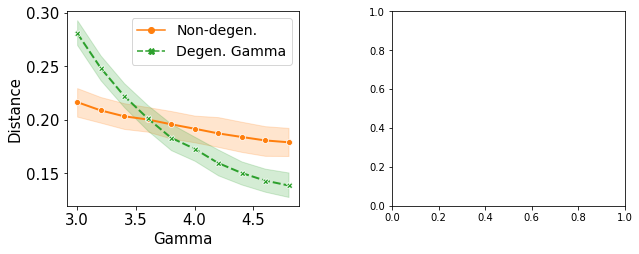

In [417]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

colors = ["C1", "C2"]

sns.lineplot(
    ax=axes[0],
    data=dist_rep_df.loc[dist_rep_df.name.isin(labels.values())], 
    x="gamma", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
    palette=colors,
)

axes[0].set_xlabel("Gamma", fontsize=15)
axes[0].set_ylabel("Distance", fontsize=15)
axes[0].set_xlim(left=dist_rep_df.gamma.min()*0.97)
# axes[0].set_ylim(bottom=0., top=1.)
# axes[0].set_xscale("log", base=2)
axes[0].tick_params(labelsize=15)
axes[0].legend(fontsize=14)

# axes[0].legend(
#     fontsize=14, bbox_to_anchor=(1.5, 1.2), ncol=4, #columnspacing=0.7, handletextpad=0.01
# )
# axes[2].legend(
#     fontsize=14, bbox_to_anchor=(1., 1.), #columnspacing=0.7, handletextpad=0.01
# )

plt.subplots_adjust(
    top=.8,
    wspace=0.4,
)
# plt.savefig(f"../figs/high_dim/dist_gamma_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

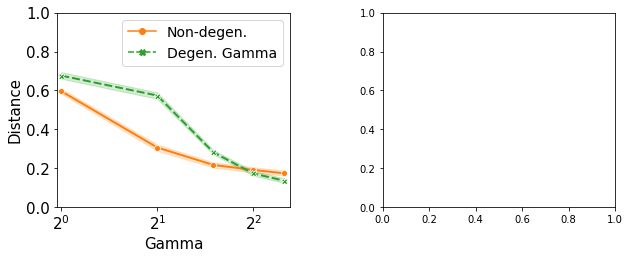

In [334]:
# n = 40
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

colors = ["C1", "C2"]

sns.lineplot(
    ax=axes[0],
    data=dist_rep_df.loc[dist_rep_df.name.isin(labels.values())], 
    x="gamma", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
    palette=colors,
)

axes[0].set_xlabel("Gamma", fontsize=15)
axes[0].set_ylabel("Distance", fontsize=15)
axes[0].set_xlim(left=dist_rep_df.gamma.min()*0.97)
axes[0].set_ylim(bottom=0., top=1.)
axes[0].set_xscale("log", base=2)
axes[0].tick_params(labelsize=15)
axes[0].legend(fontsize=14)

# axes[0].legend(
#     fontsize=14, bbox_to_anchor=(1.5, 1.2), ncol=4, #columnspacing=0.7, handletextpad=0.01
# )
# axes[2].legend(
#     fontsize=14, bbox_to_anchor=(1., 1.), #columnspacing=0.7, handletextpad=0.01
# )

plt.subplots_adjust(
    top=.8,
    wspace=0.4,
)
# plt.savefig(f"../figs/high_dim/dist_gamma_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

# CDF

In [424]:
g_degen = 4.6
g_degen_ind = gammas.index(g_degen)

g_nondegen = 3.
g_nondegen_ind = gammas.index(g_nondegen)


## Initialise classes again with appropriate $t$

In [429]:
# non-degenerate
ts_nondegen = res_exact_list[g_nondegen_ind].loc[d, "expectation"] * np.linspace(-0.5, 2.5, 101)
lim_res_nondegen = initialize_class(
    g_ind=g_nondegen_ind, 
    
    gammas=gammas, 
    res_exact_list=res_exact_list,
    stats_res_list=stats_res_list,
    ts=ts_nondegen,
)

# degenerate
ts_degen = res_exact_list[g_degen_ind].loc[d, "expectation"] * np.linspace(-0.5, 2.5, 101)
lim_res_degen = initialize_class(
    g_ind=g_degen_ind, 
    gammas=gammas, 
    res_exact_list=res_exact_list,
    stats_res_list=stats_res_list,
    ts=ts_degen,
)


lim_res_list_cdf = [lim_res_degen, lim_res_nondegen]

dim: 27 gamma: 3
dim: 27 gamma: 4.6


## Compute cdf

In [430]:
cdf_rep_list = []
for res in lim_res_list_cdf:
    try:
        cdf_rep = res.run(dim=d)
        cdf_rep["gamma"] = g
        cdf_rep_list.append(cdf_rep)
    
    except:
        pass
    
cdf_rep_degen = cdf_rep_list[0]
cdf_rep_nondegen = cdf_rep_list[1]

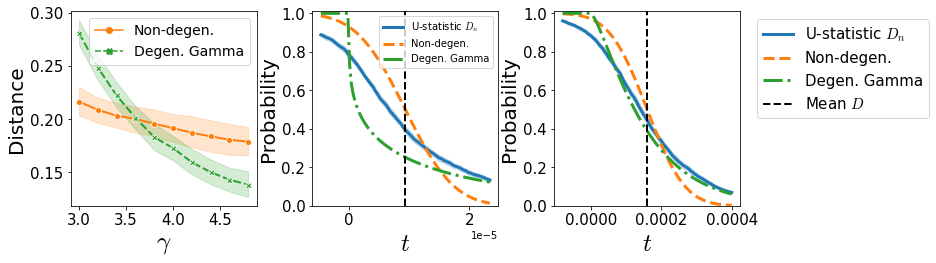

In [432]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

linestyles = ["solid", "dashed", "dashdot", "dotted"]
lw = 3

legend_cdf = {
    "probs": r"U-statistic $D_n$", 
    "cond": "Non-degen.",
    "mm_full": "Degen. Gamma",
}

colors = ["C1", "C2"]

# i. distance
sns.lineplot(
    ax=axes[0],
    data=dist_rep_df.loc[dist_rep_df.name.isin(labels.values())], 
    x="gamma", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
    palette=colors,
)

axes[0].set_xlabel(r"$\gamma$", fontsize=25)
axes[0].set_ylabel("Distance", fontsize=20)
axes[0].set_xlim(left=dist_rep_df.gamma.min()*0.97)
# axes[0].set_ylim(bottom=0., top=.7)
# axes[0].set_xscale("log", base=2)
axes[0].tick_params(labelsize=15)
axes[0].legend(fontsize=14)

# iii. ksd non-degeneracy
for i, (n, l) in enumerate(legend_cdf.items()):
    sns.lineplot(
        ax=axes[1],
        data=cdf_rep_nondegen.loc[cdf_rep_nondegen.name == n], 
        x="ts", 
        y="value", 
        label=l,
        linestyle=linestyles[i],
        linewidth=lw,
    )

# statistic expectation
axes[1].axvline(
    res_exact_list[g_nondegen_ind].loc[d, "expectation"], 
    color="k", linestyle="--", label=r"Mean $D$", linewidth=2,
)

axes[1].set_xlabel("$t$", fontsize=25)
axes[1].set_ylabel("Probability", fontsize=20)
axes[1].set_ylim(0., 1.01)
axes[1].tick_params(labelsize=15)
# axes[1].get_yaxis().set_visible(False)

# ii. ksd generacy
for i, (n, l) in enumerate(legend_cdf.items()):
    sns.lineplot(
        ax=axes[2],
        data=cdf_rep_degen.loc[cdf_rep_degen.name == n], 
        x="ts", 
        y="value", 
        label=l,
        linestyle=linestyles[i],
        linewidth=lw,
    )
# statistic expectation
axes[2].axvline(
    res_exact_list[g_degen_ind].loc[d, "expectation"], 
    color="k", linestyle="--", label=r"Mean $D$", linewidth=2,
)

axes[2].set_xlabel("$t$", fontsize=25)
axes[2].set_ylabel("Probability", fontsize=20)
axes[2].set_ylim(0., 1.01)
axes[2].tick_params(labelsize=15)
axes[2].legend([],[], frameon=False)

axes[1].locator_params(axis="x", nbins=3) # set no. of xticks 
axes[2].locator_params(axis="x", nbins=3) # set no. of xticks 

axes[2].legend(
#     cdf_legends_show,
    fontsize=15, bbox_to_anchor=(1.05, 1.), 
)

plt.subplots_adjust(
    top=0.8,
    wspace=0.3,
    hspace=.6,
)

# plt.savefig(f"../figs/high_dim/gamma_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

# KSD

In [7]:
tf.random.set_seed(1)

DELTA = 2.

BANDWIDTH_POWER = 0.

STATISTIC = "ksd"

KERNEL = RBF

dims = [27]
d = dims[0]

gammas = [3.5, 4, 5, 6, 7, 8, 10, 16, 20]
ns = [50] * len(dims)

DIR = f"../res/high_dim/gamma_ksd_dim{d}_n{ns[0]}"
SUFFIX = f"delta{DELTA}_r{BANDWIDTH_POWER}_{KERNEL.__name__}"

In [8]:
res_exact_list = []
stats_res_list = []
for g in gammas:
    if int(g) != g:
        # load analytical res
        res = pd.read_csv(
            f"{DIR}/res_analytical_{SUFFIX}_gammaksd_{g}.csv",
        )
        
        # load empirical results
        stats_res = pickle.load(
            open(f"{DIR}/stats_res_rep_{SUFFIX}_gammaksd_{g}.p", "rb"),
        )
    
    else:
        # load analytical res
        res = pd.read_csv(
            f"{DIR}/res_analytical_{SUFFIX}_gammaksd_{g}..csv",
        )
     
        # load empirical results
        stats_res = pickle.load(
            open(f"{DIR}/stats_res_rep_{SUFFIX}_gammaksd_{g}..p", "rb"),
        )

    res = res.set_index("dim", drop=False)
    res_exact_list.append(res)
    
    stats_res_list.append(stats_res)

# Initialise result classes

In [9]:
lim_res_list = []
for i, g in enumerate(gammas):
    lim_res = initialize_class(
        g_ind=i, 
        gammas=gammas, 
        res_exact_list=res_exact_list,
        stats_res_list=stats_res_list,
    )
    lim_res_list.append(lim_res)

dim: 27 gamma: 3.5
dim: 27 gamma: 4
dim: 27 gamma: 5
dim: 27 gamma: 6
dim: 27 gamma: 7
dim: 27 gamma: 8
dim: 27 gamma: 10
dim: 27 gamma: 16
dim: 27 gamma: 20


# distance

In [10]:
dist_rep_list = []
for i, g in enumerate(gammas):
    try:
        dist_rep = lim_res_list[i].compute_distance(size=100000)
        dist_rep["gamma"] = g
        dist_rep_list.append(dist_rep)
    
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


In [11]:
labels = {
    "cond": "Non-degen.", 
    "mm_full": "Degen. Gamma",
#     "mm_chi": "Degen. Chi-square",
}

dist_rep_df = pd.concat(dist_rep_list, ignore_index=True)
dist_rep_df.replace(labels, inplace=True)

In [12]:
dist_rep_df = dist_rep_df.loc[dist_rep_df.gamma > 3]

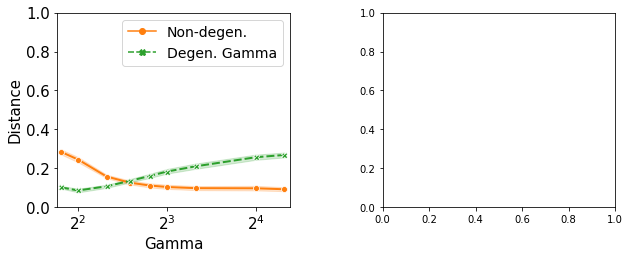

In [13]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

colors = ["C1", "C2"]

sns.lineplot(
    ax=axes[0],
    data=dist_rep_df.loc[dist_rep_df.name.isin(labels.values())], 
    x="gamma", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
    palette=colors,
)

axes[0].set_xlabel("Gamma", fontsize=15)
axes[0].set_ylabel("Distance", fontsize=15)
axes[0].set_xlim(left=dist_rep_df.gamma.min()*0.97)
axes[0].set_ylim(bottom=0., top=1.)
axes[0].set_xscale("log", base=2)
axes[0].tick_params(labelsize=15)
axes[0].legend(fontsize=14)

# axes[0].legend(
#     fontsize=14, bbox_to_anchor=(1.5, 1.2), ncol=4, #columnspacing=0.7, handletextpad=0.01
# )
# axes[2].legend(
#     fontsize=14, bbox_to_anchor=(1., 1.), #columnspacing=0.7, handletextpad=0.01
# )

plt.subplots_adjust(
    top=.8,
    wspace=0.4,
)
# plt.savefig(f"../figs/high_dim/dist_gamma_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

# CDF

In [24]:
g_degen = 4
g_degen_ind = gammas.index(g_degen)

g_nondegen = 16
g_nondegen_ind = gammas.index(g_nondegen)

# cdf_rep_degen = cdf_rep_list[g_degen_ind]
# cdf_rep_nondegen = cdf_rep_list[g_nondegen_ind]

## Initialise classes again with appropriate $t$

In [25]:
# degenerate
ts_degen = res_exact_list[g_degen_ind].loc[d, "expectation"] * np.linspace(-0.5, 2.5, 101)
lim_res_degen = initialize_class(
    g_ind=g_degen_ind, 
    gammas=gammas, 
    res_exact_list=res_exact_list,
    stats_res_list=stats_res_list,
    ts=ts_degen,
)

# non-degenerate
ts_nondegen = res_exact_list[g_nondegen_ind].loc[d, "expectation"] * np.linspace(0.5, 1.5, 101)
lim_res_nondegen = initialize_class(
    g_ind=g_nondegen_ind, 
    
    gammas=gammas, 
    res_exact_list=res_exact_list,
    stats_res_list=stats_res_list,
    ts=ts_nondegen,
)

lim_res_list_cdf = [lim_res_degen, lim_res_nondegen]

dim: 27 gamma: 4
dim: 27 gamma: 16


## compute CDF

In [26]:
cdf_rep_list = []
for res in lim_res_list_cdf:
    try:
        cdf_rep = res.run(dim=d)
        cdf_rep["gamma"] = g
        cdf_rep_list.append(cdf_rep)
    
    except:
        pass
    
cdf_rep_degen = cdf_rep_list[0]
cdf_rep_nondegen = cdf_rep_list[1]

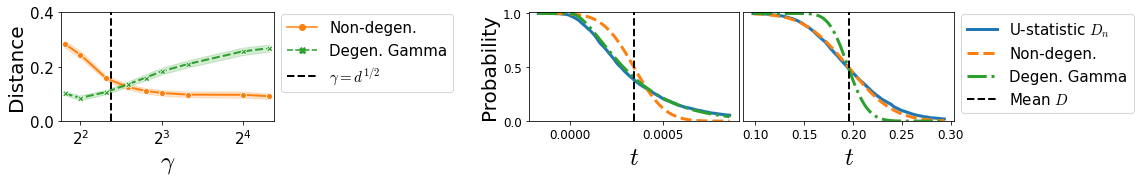

In [27]:
fig = plt.figure(figsize=(16, 2))
outer = gridspec.GridSpec(1, 2, wspace=0.8, width_ratios=(1, 2))

linestyles = ["solid", "dashed", "dashdot", "dotted"]
lw = 3

legend_cdf = {
    "probs": r"U-statistic $D_n$", 
    "cond": "Non-degen.",
    "mm_full": "Degen. Gamma",
}

colors = ["C1", "C2"]

# i. distance
ax = plt.Subplot(fig, outer[0])

sns.lineplot(
    ax=ax,
    data=dist_rep_df.loc[dist_rep_df.name.isin(labels.values())], 
    x="gamma", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
    palette=colors,
)
# regime change threshold
ax.axvline(
    d**(1/2.), 
    color="k", linestyle="--", label=r"$\gamma = d^{1/2}$", linewidth=2,
)
ax.set_xlabel(r"$\gamma$", fontsize=25)
ax.set_ylabel("Distance", fontsize=20)
ax.set_xlim(left=dist_rep_df.gamma.min()*0.97)
ax.set_ylim(bottom=0., top=.4)
ax.set_xscale("log", base=2)
ax.tick_params(labelsize=15)
ax.legend(fontsize=14)
fig.add_subplot(ax)


# ii. ksd generacy
inner = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[1], wspace=0.02,
)
ax0 = plt.Subplot(fig, inner[0])
for i, (n, l) in enumerate(legend_cdf.items()):
    sns.lineplot(
        ax=ax0,
        data=cdf_rep_degen.loc[cdf_rep_degen.name == n], 
        x="ts", 
        y="value", 
        label=l,
        linestyle=linestyles[i],
        linewidth=lw,
    )
# statistic expectation
ax0.axvline(
    res_exact_list[g_degen_ind].loc[d, "expectation"], 
    color="k", linestyle="--", label=r"Mean $D$", linewidth=2,
)

ax0.set_xlabel("$t$", fontsize=25)
ax0.set_ylabel("Probability", fontsize=20)
ax0.set_ylim(0., 1.01)
ax0.tick_params(labelsize=12)
ax0.legend([],[], frameon=False)
fig.add_subplot(ax0)

# iii. ksd non-degeneracy
ax1 = plt.Subplot(fig, inner[1])
for i, (n, l) in enumerate(legend_cdf.items()):
    sns.lineplot(
        ax=ax1,
        data=cdf_rep_nondegen.loc[cdf_rep_nondegen.name == n], 
        x="ts", 
        y="value", 
        label=l,
        linestyle=linestyles[i],
        linewidth=lw,
    )

# statistic expectation
ax1.axvline(
    res_exact_list[g_nondegen_ind].loc[d, "expectation"], 
    color="k", linestyle="--", label=r"Mean $D$", linewidth=2,
)

ax1.set_xlabel("$t$", fontsize=25)
ax1.set_ylabel("Probability", fontsize=20)
ax1.set_ylim(0., 1.01)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(labelsize=12)
fig.add_subplot(ax1)

ax.legend(
#     cdf_legends_show,
    fontsize=15, bbox_to_anchor=(1.0, 1.05), 
)
# ax.legend(fontsize=12)

ax1.legend(
#     cdf_legends_show,
    fontsize=15, bbox_to_anchor=(1.0, 1.05), 
)
ax0.locator_params(axis="x", nbins=3) # set no. of xticks 

fig.show()

# plt.savefig(f"../figs/high_dim/gamma_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")